# Learn the Lennard Jones potential using kernel methods
### Tristan Bereau (MPIP)
`bereau@mpip-mainz.mpg.de`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time
from matplotlib import rc
rc('text', usetex=True)
from sklearn.model_selection import train_test_split
import scipy
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics import mean_absolute_error
np.set_printoptions(precision=4, suppress=True)

np.random.seed(1)

In [234]:
# Define the Lennard Jones potential. 
# Work in reduced units \sigma = 1 and \epsilon = 1.
def lj(r):
    return 4.*((1/r)**12 - (1/r)**6)

def morse(r,d=1.8,a=5.0,s=1.1):
    return d*((1-np.exp(-a*(r-s)))**2-1)

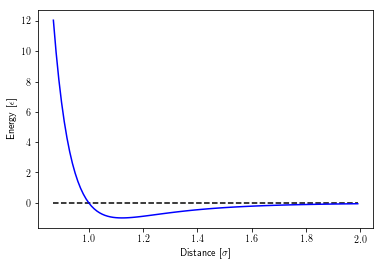

In [235]:
# Plot
t1 = np.arange(0.87, 2.0, 0.01)

ax1 = plt.subplot(111)
ax1.set_xlabel('Distance [$\sigma$]')
ax1.set_ylabel('Energy [$\epsilon$]')
# 0 energy
ax1.plot(t1, [0]*t1, '--k')
# LJ potential
ax1.plot(t1, lj(t1), 'b')
plt.show()

In [236]:
def split_train_test(N, test_frac):
    # Draw random numbers. Shift them between 0.87 and 2.0
    xmin, xmax = 0.87, 2.0
    t1 = np.random.rand(N) * (xmax - xmin) + xmin
    X, y = t1, lj(t1)
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=test_frac, random_state=int(time.time()))
#     print("Training: {:d} samples; Test: {:d} samples".format(len(X_train),len(X_test)))
    return X_train, X_test, y_train, y_test

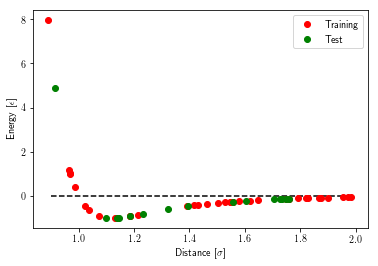

In [290]:
# Split N datapoints between training and test
N = 50
test_frac = 0.3
xtr, xte, ytr, yte = split_train_test(N, test_frac)

ax1 = plt.subplot(111)
ax1.set_xlabel('Distance [$\sigma$]')
ax1.set_ylabel('Energy [$\epsilon$]')
# 0 energy
t1 = np.arange(0.9, 2.0, 0.01)
ax1.plot(t1, [0]*t1, '--k')
# Training points
ax1.plot(xtr, ytr, 'or', label=u'Training')
# Test points
ax1.plot(xte, yte, 'og', label=u'Test')
plt.legend(loc='upper right')
plt.show()

## Implementation of ML model
Representation $x$: distance $r$

Laplacian kernel with L2 norm: 

$K(x,x') = \exp\left(-\frac{||x-x'||^1_2}{\sigma}\right)$

In [351]:
# Train a kernel machine
def train_model(Xtrain, ytrain, sigma, lambd, prior):
    # Kernel - size num_obs*num_obs
    # Use a laplacian kernel with L1 norm
    pairwise_dists = squareform(pdist(Xtrain, 'euclidean'))
    Ktrain = scipy.exp(- pairwise_dists / sigma) - lambd*np.identity(len(Xtrain))
    target = ytrain - prior
    Kinv   = np.linalg.inv(Ktrain)
    alpha  = np.dot(target, Kinv)
    # Return optimized coefficients
    return alpha, Kinv

In [352]:
# Make predictions from a ML model
def predict_model(Xpred, Xtrain, alpha, K_inv, sigma, prior):
    # Predict each pair
    pairwise_dists = cdist(Xtrain, Xpred, 'euclidean')
    K_tr_te = scipy.exp(- pairwise_dists / sigma)
    # Mean value: prediction
    # K* \alpha (+ \mu)
    pred = np.dot(alpha, K_tr_te) + prior
    # Accuracy of the prediction
    # K** - K* K^{-1} K*
    pairwise_dists = cdist(Xpred, Xpred, 'euclidean')
    K_te_te = scipy.exp(- pairwise_dists / sigma)
    accur = K_te_te - np.dot(K_tr_te.T, np.dot(K_inv, K_tr_te))
    return pred, accur.diagonal()

In [353]:
def build_model(N, test_frac, sigma, lambd, prior=False):
    # Build train/test dataset
    xtr, xte, ytr, yte = split_train_test(N, test_frac)
    Xtrain, Xtest = xtr.reshape((len(xtr),1)), xte.reshape((len(xte),1))
    
    # Optionally add a prior (Morse potential)
    xtrpr, xtepr = np.zeros(len(xtr)), np.zeros(len(xte))
    if prior is True:
        xtrpr = morse(xtr)
        xtepr = morse(xte)

    # Train model
    alpha, Kinv = train_model(Xtrain, ytr, sigma, lambd, prior=xtrpr)

    # Test model
    ypred, accur = predict_model(Xtest, Xtrain, alpha, Kinv, sigma, prior=xtepr)

    # Mean absolute error
    mae = mean_absolute_error(ypred, yte)
    
    # Sort xte, yte, ypred, and accur
    xteinds = xte.argsort()
    
    return xtr, xte[xteinds], ytr, yte[xteinds], ypred[xteinds], accur[xteinds], mae

## First test

In [354]:
Xtrain, Xtest, ytrain, ytest, ypred, accur, mae = build_model(N=50, test_frac=0.5, sigma=1.0, lambd=1e-6, prior=False)

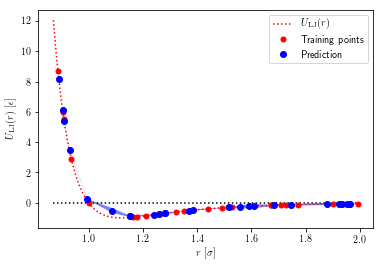

In [355]:
# Plot the function, the prediction and the 95% confidence interval
t1 = np.arange(0.87, 2.0, 0.01)
fig = plt.figure()
plt.rc('text', usetex=True)
plt.plot(t1, lj(t1), 'r:', label=r'$U_{\rm LJ}(r)$')
plt.plot(t1, [0]*t1, 'k:')
plt.plot(Xtrain, ytrain, 'r.', markersize=10, label=u'Training points')
plt.plot(Xtest, ypred, 'bo', label=u'Prediction')
plt.fill(np.concatenate([Xtest, Xtest[::-1]]),
         np.concatenate([ypred - 1.9600 * accur,
                        (ypred + 1.9600 * accur)[::-1]]),
         alpha=.5, fc='b', ec='None')
plt.xlabel('$r \  [\sigma]$')
plt.ylabel(r'$U_{\rm LJ}(r) \  [\epsilon]$')
plt.legend(loc='upper right')
plt.show()

## Scan hyperparameters

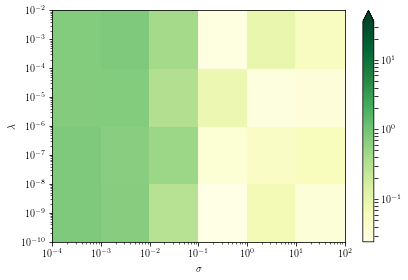

In [356]:
# Scan hyperparameters
sigmas  = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]
lambds  = [1e-10,1e-8,1e-6,1e-4,1e-2]
Ndata   = 100
te_frac = 0.3
numexp  = 10
hypersurf = np.zeros((len(sigmas),len(lambds)))
for i,s in enumerate(sigmas):
    for j,l in enumerate(lambds):
        mae_k = []
        for k in range(numexp):
            Xtrain, Xtest, ytrain, ytest, ypred, accur, mae = build_model(N=Ndata, test_frac=te_frac, sigma=s, lambd=l)
            mae_k.append(mae)
        hypersurf[i,j] = np.mean(mae_k)
# Plot the surface
fig, ax = plt.subplots()
pcm = ax.pcolor(sigmas, lambds, hypersurf.T,
                   norm=colors.LogNorm(vmin=hypersurf.min(), vmax=hypersurf.max()),
                   cmap='YlGn')
ax.semilogx()
ax.semilogy()
ax.set_xlabel('$\sigma$')
ax.set_ylabel('$\lambda$')
fig.colorbar(pcm, ax=ax, extend='max')
fig.tight_layout()
plt.show()

## Building our first learning curve

In [357]:
# Build learning curves
numdata = [1,2,5,10,20,50,100,200,500,1000]
numexp  = 20
te_frac = 0.3
sig     = 2e-1
lambd   = 1e-9
maes = []
maes_std = []
for n in numdata:
    print n,
    mae_i = []
    for j in range(numexp):
        Xtrain, Xtest, ytrain, ytest, ypred, accur, mae = build_model(N=n, test_frac=te_frac, 
                                                                      sigma=sig, lambd=lambd, prior=False)
        mae_i.append(mae)
    maes.append(np.mean(mae_i))
    maes_std.append(scipy.stats.sem(mae_i))

1 2 5 10 20 50 100 200 500 1000


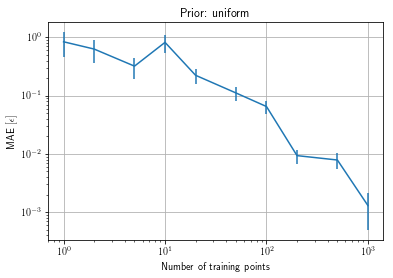

In [358]:
# Plot the learning curves
fig = plt.figure()
plt.rc('text', usetex=True)
plt.errorbar(numdata, maes, yerr=maes_std)
plt.loglog()
axes = plt.gca()
# axes.set_xlim([min(numdata)*0.5,max(numdata)*1.1])
# ylim = [min(maes)*0.8,max(maes)*2]
# axes.set_ylim(ylim)
plt.xlabel('Number of training points')
plt.ylabel('MAE $[\epsilon]$')
plt.title('Prior: uniform')
plt.grid()
plt.show()

## Add a prior

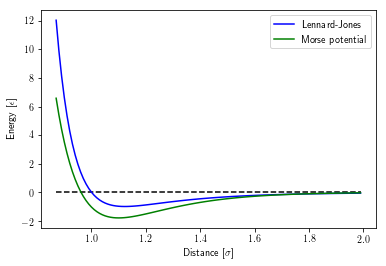

In [359]:
# Plot
t1 = np.arange(0.87, 2.0, 0.01)

ax1 = plt.subplot(111)
ax1.set_xlabel('Distance [$\sigma$]')
ax1.set_ylabel('Energy [$\epsilon$]')
# 0 energy
ax1.plot(t1, [0]*t1, '--k')
# LJ potential
ax1.plot(t1, lj(t1), 'b', label=u'Lennard-Jones')
# Repulsive model
ax1.plot(t1, morse(t1), 'g-', label=u'Morse potential')
plt.legend(loc='upper right')
plt.show()

In [360]:
# Build learning curves with nonuniform prior
maes_pr = []
maes_pr_std = []
for n in numdata:
    print n,
    mae_i = []
    for j in range(numexp):
        Xtrain, Xtest, ytrain, ytest, ypred, accur, mae = build_model(N=n, test_frac=te_frac, 
                                                                      sigma=sig, lambd=lambd, prior=True)
        mae_i.append(mae)
    maes_pr.append(np.mean(mae_i))
    maes_pr_std.append(scipy.stats.sem(mae_i))

1 2 5 10 20 50 100 200 500 1000


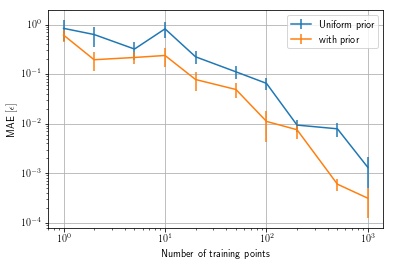

In [362]:
# Plot the learning curves
fig = plt.figure()
plt.rc('text', usetex=True)
plt.errorbar(numdata, maes, yerr=maes_std, label=u'Uniform prior')
plt.errorbar(numdata, maes_pr, yerr=maes_pr_std, label=u'with prior')
plt.loglog()
axes = plt.gca()
plt.xlabel('Number of training points')
plt.ylabel('MAE $[\epsilon]$')
plt.legend(loc='upper right')
plt.grid()
plt.show()